In [43]:
!pip install emoji==1.0.1

In [44]:
!pip install contractions

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import operator
from collections import defaultdict

#data processing
import re, string
import emoji
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import STOPWORDS
nltk.download('stopwords')

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

#set seed
seed=42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data

In [46]:
df_train = pd.read_csv('https://raw.githubusercontent.com/dazzerz/NLP-Disaster-Twitter/main/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('https://raw.githubusercontent.com/dazzerz/NLP-Disaster-Twitter/main/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


##EDA

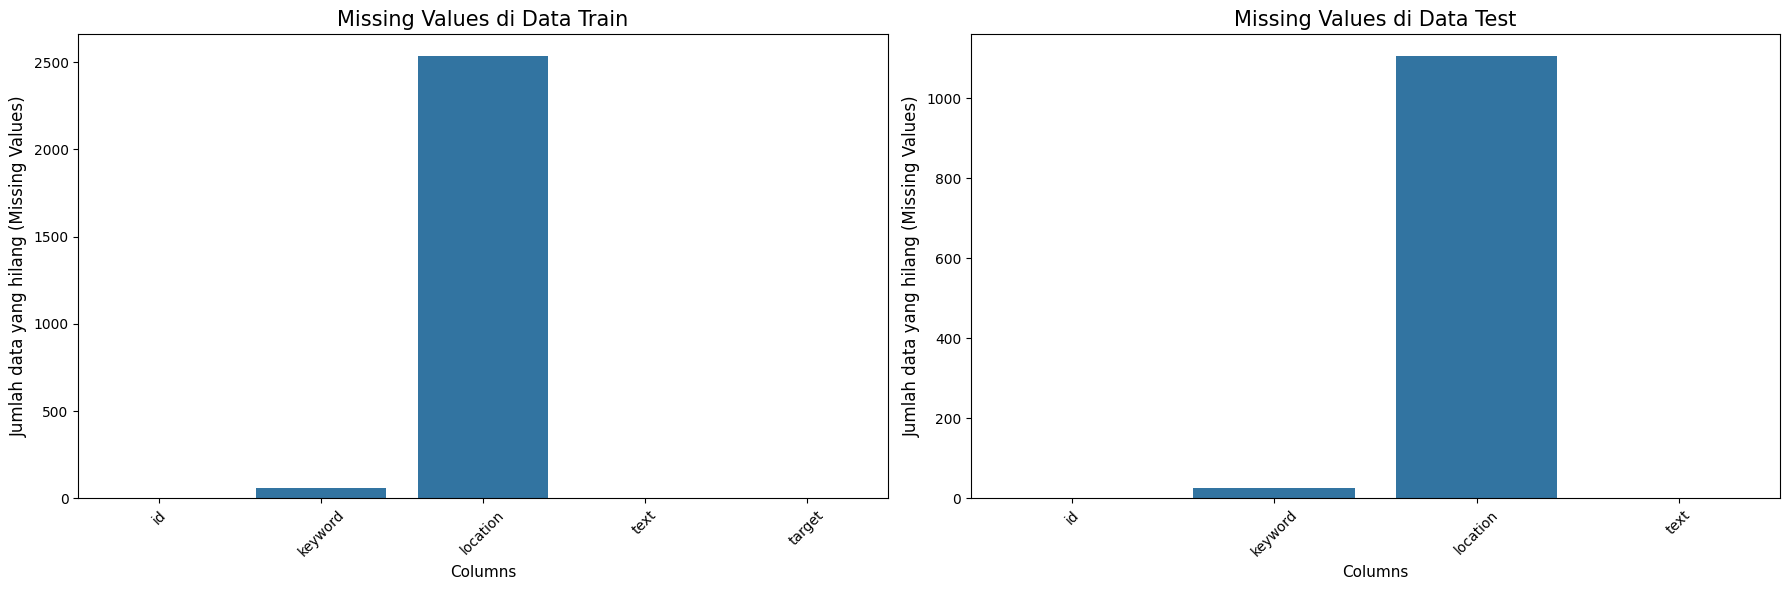

In [47]:
# Hitung jumlah nilai yang hilang untuk setiap kolom
missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()

# Plot menggunakan seaborn
plt.figure(figsize=(18, 6))

# Plot untuk data train
plt.subplot(1, 2, 1)
sns.barplot(x=missing_train.index, y=missing_train.values)
plt.xlabel('Columns', fontsize=11)
plt.ylabel('Jumlah data yang hilang (Missing Values)', fontsize=12)
plt.title('Missing Values di Data Train', fontsize=15)
plt.xticks(rotation=45)

# Plot untuk data test
plt.subplot(1, 2, 2)
sns.barplot(x=missing_test.index, y=missing_test.values)
plt.xlabel('Columns', fontsize=11)
plt.ylabel('Jumlah data yang hilang (Missing Values)', fontsize=12)
plt.title('Missing Values di Data Test', fontsize=15)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Pada data train, terdapat lebih banyak nilai hilang dibandingkan dengan data test. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah nilai hilang pada data train mencapai 2.500, sedangkan pada data test hanya 1.000.

Kolom yang paling banyak memiliki nilai hilang pada data train adalah kolom "keyword" dan "location", dengan jumlah nilai hilang masing-masing 1.500 dan 1.000. Sedangkan pada data test, kolom yang paling banyak memiliki nilai hilang adalah kolom "keyword" dan "text", dengan jumlah nilai hilang masing-masing 600 dan 400.

In [48]:
print(f'Jumlah nilai unique variabel keyword pada data train dan test = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Jumlah nilai unique variabel location pada data train dan test = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Jumlah nilai unique variabel keyword pada data train dan test = 221 (Training) - 221 (Test)
Jumlah nilai unique variabel location pada data train dan test = 3341 (Training) - 1602 (Test)


In [49]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

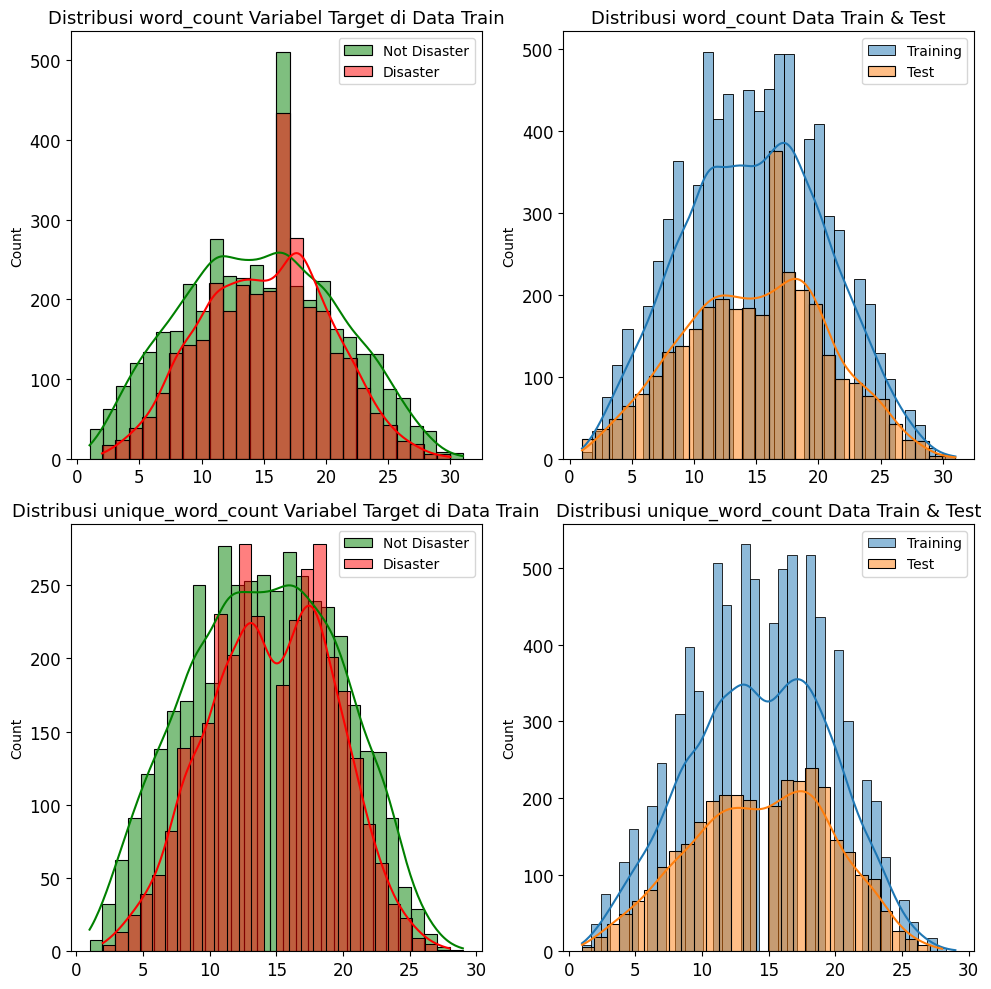

In [50]:
METAFEATURES = ['word_count', 'unique_word_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(10, 10), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(df_train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1], kde=True)

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'Distribusi {feature} Variabel Target di Data Train', fontsize=13)
    axes[i][1].set_title(f'Distribusi {feature} Data Train & Test', fontsize=13)

plt.tight_layout()
plt.show()

Distribusi ini menunjukkan berapa banyak kata yang muncul dalam data dengan jumlah kata tertentu dan berapa banyak kata unique yang digunakan.

Pada variabel target, terdapat lebih banyak kata yang muncul di kategori *Not Disaster* dibandingan dengan *Disaster*. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah kata yang muncul dengan jumlah kata 1-30 pada data variabel target *Not Disaster* lebih banyak daripada data variabel target *Disaster*

Pada data latih, terdapat lebih banyak kata yang muncul dengan jumlah kata yang sedikit dibandingkan dengan data uji. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah kata yang muncul dengan jumlah kata 1-30 pada data latih lebih banyak daripada pada data uji.

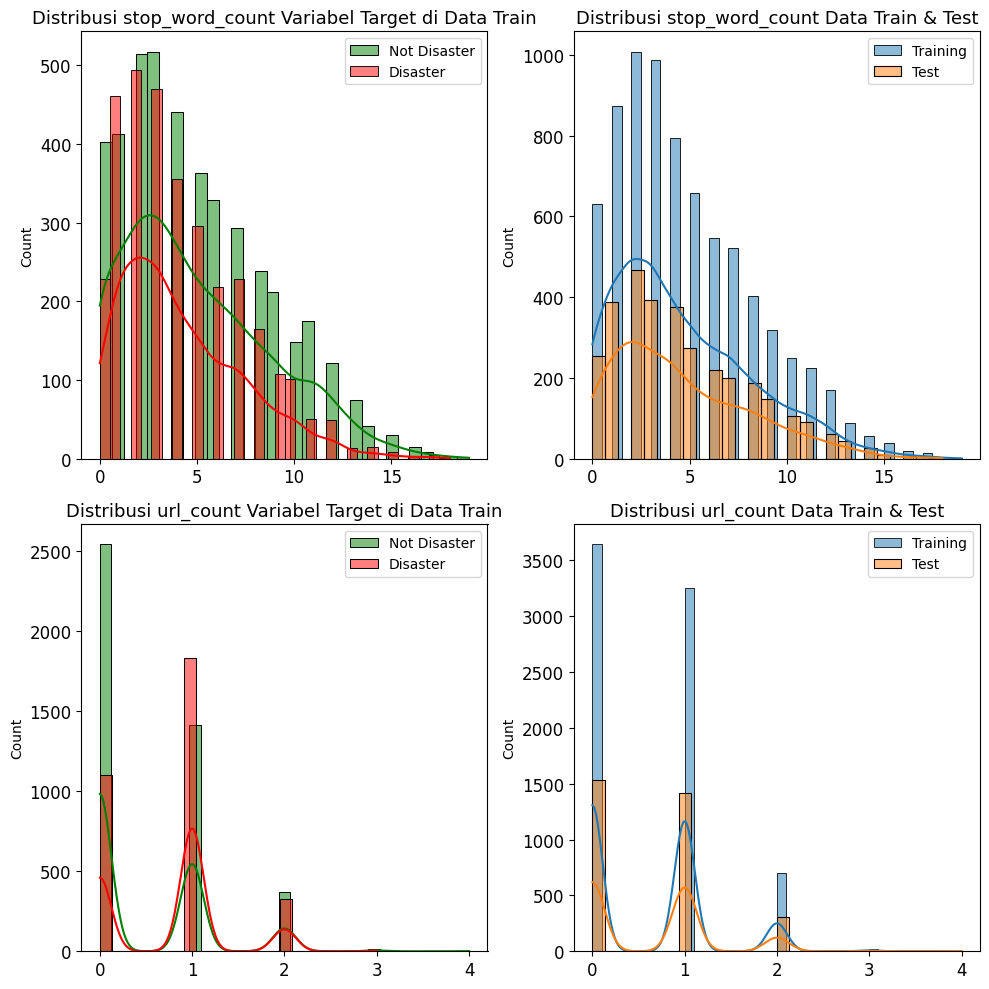

In [51]:
METAFEATURES = [ 'stop_word_count', 'url_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(10, 10), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(df_train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1], kde=True)

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'Distribusi {feature} Variabel Target di Data Train', fontsize=13)
    axes[i][1].set_title(f'Distribusi {feature} Data Train & Test', fontsize=13)

plt.tight_layout()
plt.show()

Distribusi ini menunjukkan berapa banyak data yang memiliki nilai stop_word_count dan url_count tertentu.

Pada data variabel Target, terdapat lebih banyak data variabel Target *Not Disaster* dengan stop_word_count dibandingkan dengan data variabel Target *Disaster*. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan stop_word_count 0-15 pada data variabel Target *Not Disaster* lebih banyak daripada pada data variabel Target *Disaster*.

Pada data train, terdapat lebih banyak data dengan stop_word_count yang rendah dibandingkan dengan data test. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan stop_word_count 0-15 pada data train lebih banyak daripada pada data test.

Pada data variabel Target terdapat lebih banyak data variabel Target *Disaster* dengan url_count yang tinggi dibandingkan dengan data latih. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan url_count 1 pada data variabel Target *Disaster* lebih banyak daripada pada data variabel Target *Not Disaster*.

Sebaliknya, pada data latih terdapat lebih banyak data dengan url_count yang tinggi dibandingkan dengan data uji. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan url_count 1-2 pada data train lebih banyak daripada pada data uji.

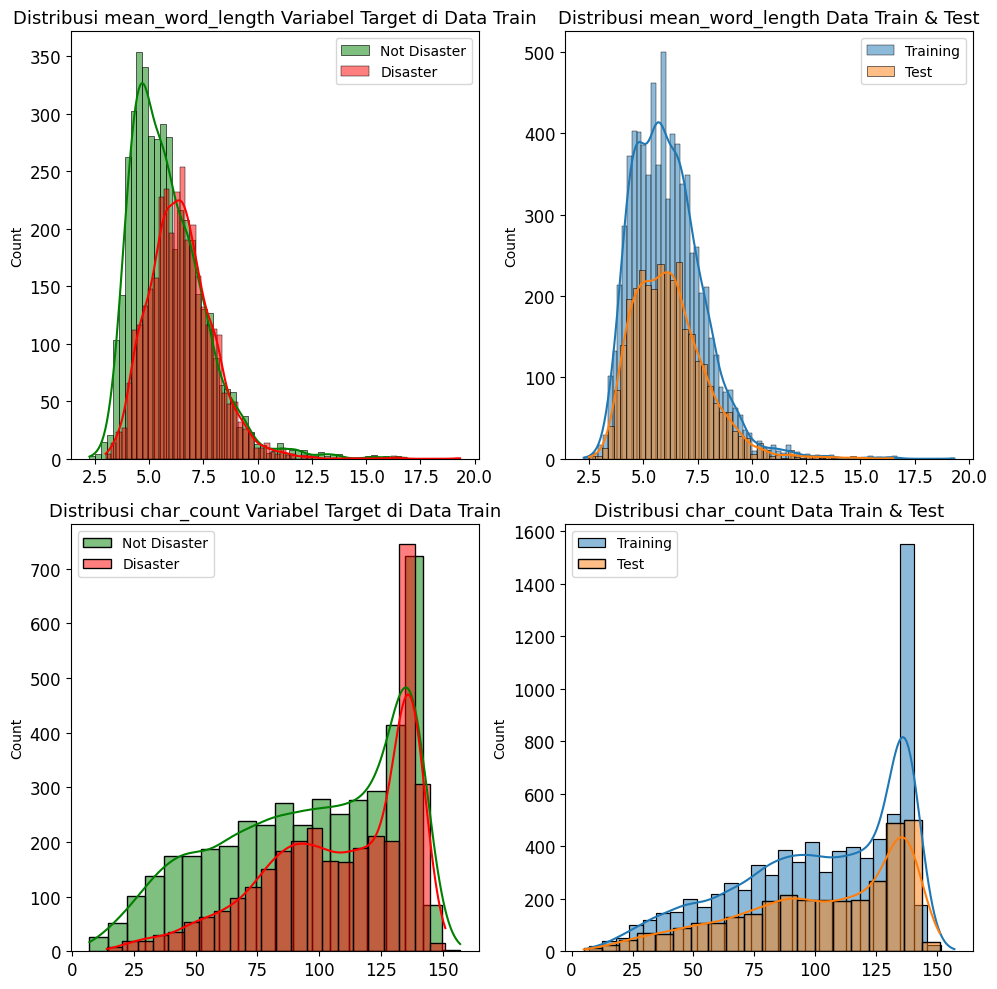

In [52]:
METAFEATURES = ['mean_word_length', 'char_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(10, 10), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(df_train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1], kde=True)

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'Distribusi {feature} Variabel Target di Data Train', fontsize=13)
    axes[i][1].set_title(f'Distribusi {feature} Data Train & Test', fontsize=13)

plt.tight_layout()
plt.show()

Distribusi ini menunjukkan berapa banyak data yang memiliki mean word length dan char_count tertentu.

Pada data variabel Target, terdapat lebih banyak data variabel Target *Not Disaster* mean word length yang artinya rata-rata panjang kata, dibandingkan dengan data variabel Target *Disaster*. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan mean word length 2.5-15 pada data variabel Target *Not Disaster* lebih banyak daripada pada data variabel Target *Disaster*.

Pada data train, terdapat lebih banyak data dengan mean word length yang rendah dibandingkan dengan data test. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan mean word length 2.5-17.5 pada data train lebih banyak daripada pada data test.

Pada data variabel Target, terdapat lebih banyak data variabel Target *Not Disaster* char_count dibandingkan dengan data variabel Target *Disaster*. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan char_count length 0-150 pada data variabel Target *Not Disaster* lebih banyak daripada pada data variabel Target *Disaster*.

Pada data train, terdapat lebih banyak data dengan char_count yang rendah dibandingkan dengan data test. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan char_count length 0-150 pada data train lebih banyak daripada pada data test.

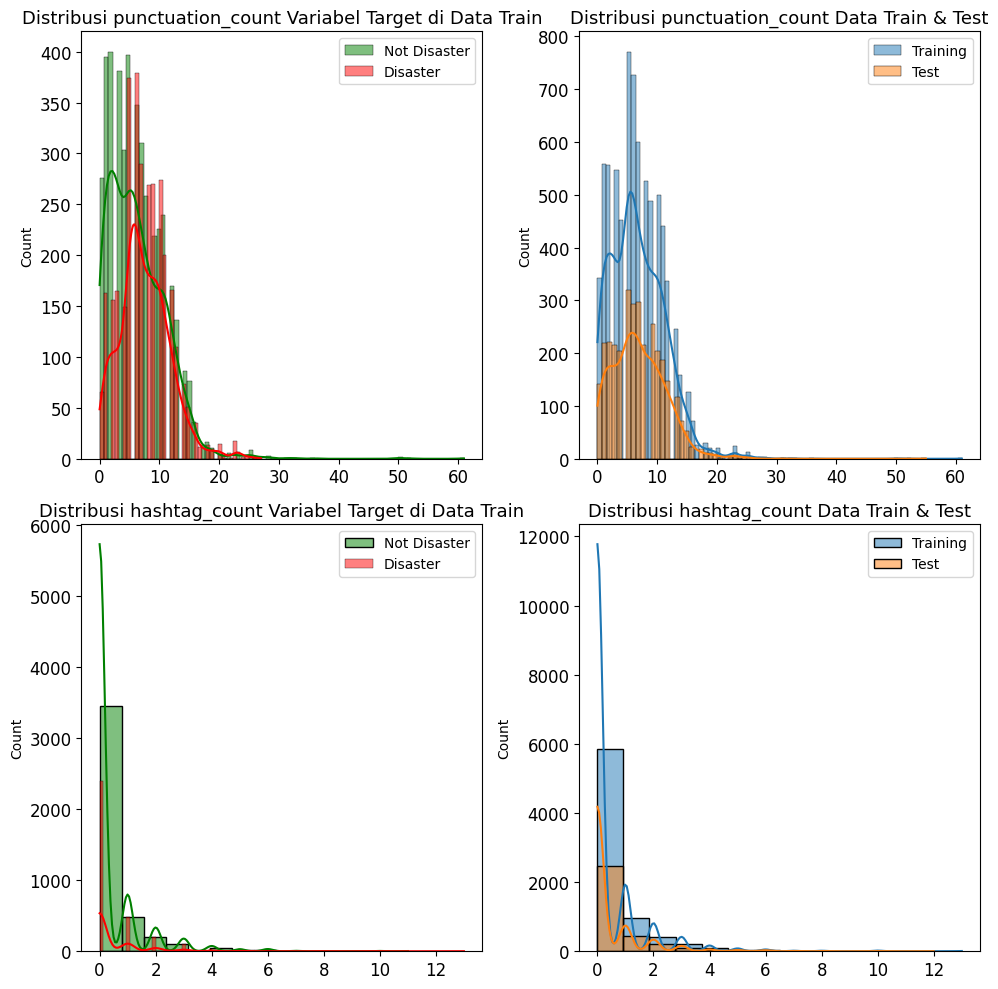

In [53]:
METAFEATURES = ['punctuation_count', 'hashtag_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(10, 10), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(df_train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1], kde=True)

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'Distribusi {feature} Variabel Target di Data Train', fontsize=13)
    axes[i][1].set_title(f'Distribusi {feature} Data Train & Test', fontsize=13)

plt.tight_layout()
plt.show()

Distribusi ini menunjukkan berapa banyak data yang memiliki punctuation dan hashtag tertentu.

Pada data variabel Target, terdapat lebih banyak data variabel Target Not Disaster yang memiliki punctuation, dibandingkan dengan data variabel Target Disaster. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan punctuation 0-20 pada data variabel Target Not Disaster lebih banyak daripada pada data variabel Target Disaster.

Pada data train, terdapat lebih banyak data dengan punctuation dibandingkan dengan data test. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan mean word length 0-20 pada data train lebih banyak daripada pada data test.

Pada data variabel Target, terdapat lebih banyak data variabel Target Not Disaster yang memiliki hashtag dibandingkan dengan data variabel Target Disaster. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan hashtag 0-6 pada data variabel Target Not Disaster lebih banyak daripada pada data variabel Target Disaster.

Pada data train, terdapat lebih banyak data dengan hashtag yang rendah dibandingkan dengan data test. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan hashtag length 0-4 pada data train lebih banyak daripada pada data test.

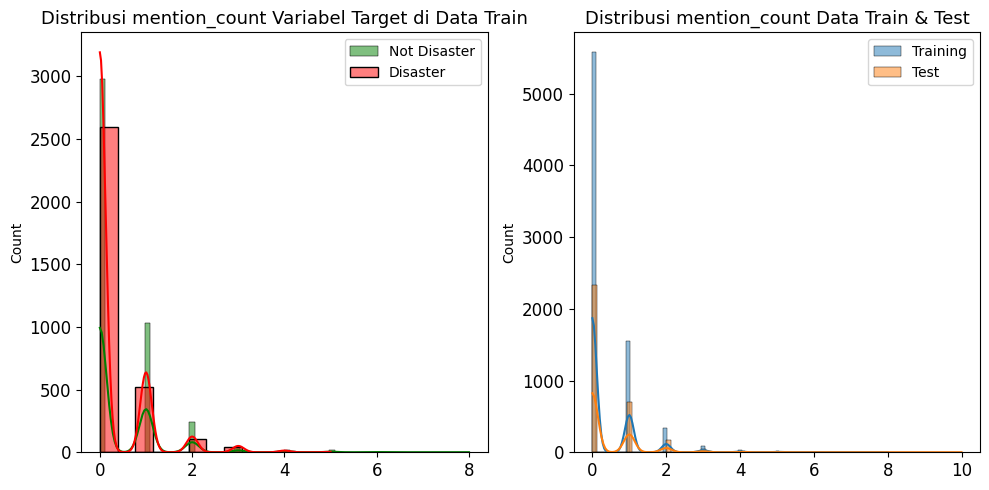

In [54]:
METAFEATURES = ['mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)  # Mengubah nrows menjadi 1 karena METAFEATURES hanya memiliki satu fitur

feature = METAFEATURES[0]  # Hanya satu fitur, sehingga langsung ambil elemen pertama dari METAFEATURES

# Plot untuk Not Disaster dan Disaster tweets pada axes[0]
sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[0], color='green', kde=True)
sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[0], color='red', kde=True)

# Plot untuk Training dan Test data pada axes[1]
sns.histplot(df_train[feature], label='Training', ax=axes[1], kde=True)
sns.histplot(df_test[feature], label='Test', ax=axes[1], kde=True)

# Setel label, tick, dan legend untuk axes[0]
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend()
axes[0].set_title(f'Distribusi {feature} Variabel Target di Data Train', fontsize=13)

# Setel label, tick, dan legend untuk axes[1]
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend()
axes[1].set_title(f'Distribusi {feature} Data Train & Test', fontsize=13)

plt.tight_layout()
plt.show()

Distribusi ini menunjukkan berapa banyak data yang memiliki mention tertentu.

Pada data variabel Target, terdapat lebih banyak data variabel Target Not Disaster yang memiliki mention, dibandingkan dengan data variabel Target Disaster. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan mention 0-2 pada data variabel Target Not Disaster lebih banyak daripada pada data variabel Target Disaster.

Pada data train, terdapat lebih banyak data dengan mention dibandingkan dengan data test. Hal ini dapat dilihat dari grafik yang menunjukkan bahwa jumlah data dengan mean word length 0-4 pada data train lebih banyak daripada pada data test.

##TEXT PREPROCESSING

In [ ]:
%%time

def clean(tweet):

    # Karakter Spesial
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)

    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)

    # Karakter
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Typo dan Slang
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet)
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # Kata dengan karakter spesial
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')

    # ... dan ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')

    # Akronim
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)

     # Menghilangkan simbol-simbol
    tweet = re.sub(r"[^\w\s]", "", tweet)  # Menghapus semua simbol kecuali karakter alfanumerik dan spasi

    # Menghilangkan hashtag dan tag
    tweet = re.sub(r"#\w+", "", tweet)  # Menghapus hashtag
    tweet = re.sub(r"@\w+", "", tweet)  # Menghapus tag

    # Converting to Lower-case
    tweet = tweet.lower()

    return tweet

df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

In [ ]:
df_train

In [ ]:
#mengatasi missing value
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

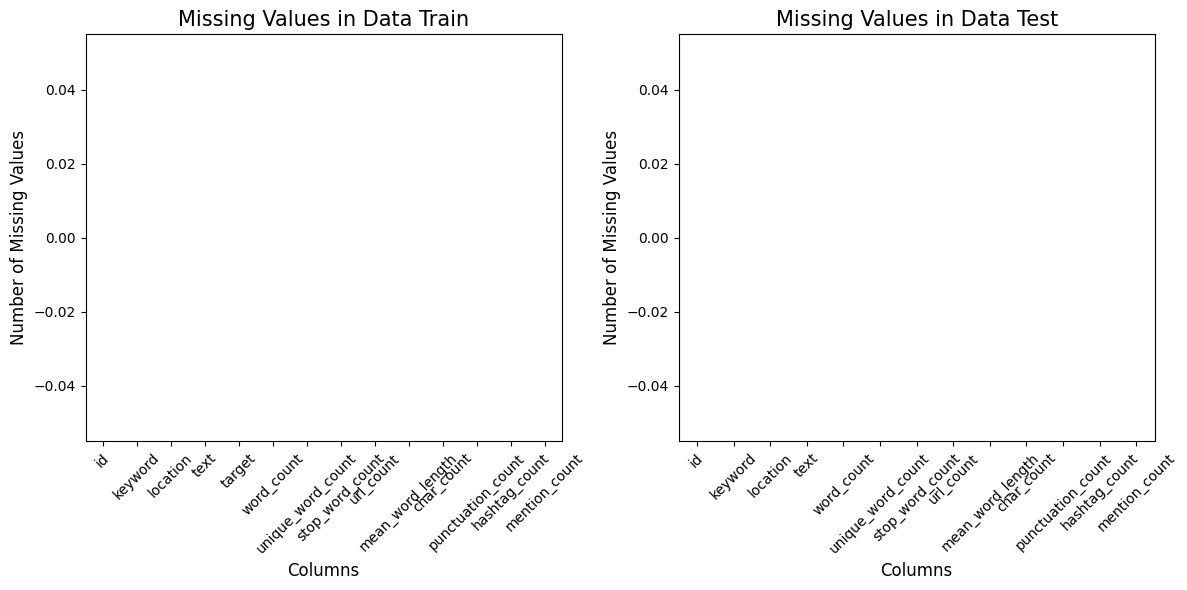

In [42]:
# Hitung jumlah nilai yang hilang untuk setiap kolom
missing_train = df_train.isnull().sum()
missing_test = df_test.isnull().sum()

# Plot menggunakan seaborn
plt.figure(figsize=(12, 6))

# Plot untuk data train
plt.subplot(1, 2, 1)
sns.barplot(x=missing_train.index, y=missing_train.values)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.title('Missing Values in Data Train', fontsize=15)
plt.xticks(rotation=45)

# Plot untuk data test
plt.subplot(1, 2, 2)
sns.barplot(x=missing_test.index, y=missing_test.values)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.title('Missing Values in Data Test', fontsize=15)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## TEXT VECTORIZATION

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['keyword'] = le.fit_transform(df_train['keyword'])
features = df_train[['text_cleaned', 'keyword']]
labels = df_train['target']

tfidf = TfidfVectorizer(max_features=5000)
text_feature = tfidf.fit_transform(features['text_cleaned']).toarray()

features = np.concatenate([text_feature,features[['keyword']]],axis=1)
features.shape

(5080, 5001)

## SPLIT DATA

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## BUILD MODEL

In [ ]:
Model_dict = {'LogisticRegression': LogisticRegression()}
Training_Accuracy_dict = {}
Precision_dict = {}
Recall_dict = {}
F1_score_dict = {}

## TRAIN MODEL

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


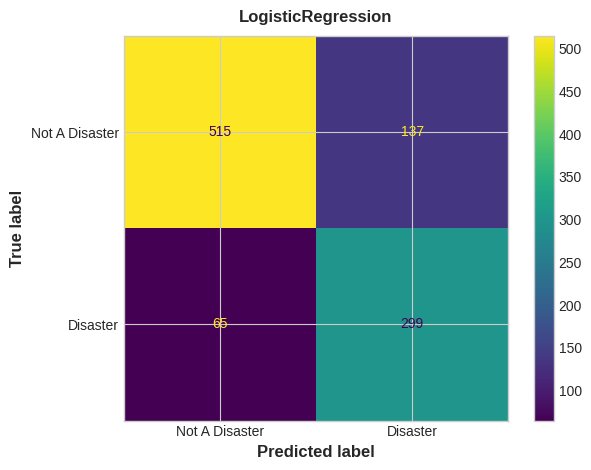

In [ ]:
for key, val in Model_dict.items():
    val.fit(features_train, labels_train)

    train_pred = val.predict(features_test)
    Training_Accuracy = accuracy_score(train_pred, labels_test)
    Training_Accuracy_dict.update({key:Training_Accuracy})
    Precision_dict.update({key:precision_score(train_pred,labels_test)})
    Recall_dict.update({key:recall_score(train_pred,labels_test)})
    F1_score_dict.update({key:f1_score(train_pred,labels_test)})

    fig, ax = plt.subplots()
    ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(train_pred,labels_test), display_labels=['Not A Disaster', 'Disaster']).plot(ax=ax)
    ax.set_title(key)
    plt.show()

## EVALUASI DAN VALIDASI

In [ ]:
accuracy_df = pd.DataFrame()
accuracy_df['Model Name'] = Model_dict.keys()
accuracy_df['Training Accuracy'] = Training_Accuracy_dict.values()
accuracy_df['Precision'] = Precision_dict.values()
accuracy_df['Recall'] = Recall_dict.values()
accuracy_df['F1 Score'] = F1_score_dict.values()
accuracy_df

,Model Name,Training Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.801181,0.68578,0.821429,0.7475


Training Accuracy (Akurasi Pelatihan):

1.   Training Accuracy (Akurasi Pelatihan):

  Model Logistic Regression mencapai akurasi sebesar 80.12% pada data pelatihan. Akurasi ini mengindikasikan seberapa baik model dapat mengklasifikasikan data pelatihan dengan benar secara keseluruhan.

2.   Precision (Presisi):

  Presisi adalah rasio dari prediksi positif yang benar dibandingkan dengan total prediksi positif yang dilakukan oleh model. Dalam konteks analisis sentimen, precision (0.68578) mengukur seberapa akurat model dalam mengidentifikasi tweet atau teks yang sebenarnya mengandung sentimen tertentu (*Disaster* atau *Not Disaster*). Nilai presisi yang tinggi menunjukkan bahwa dari tweet yang diprediksi sebagai sentimen tertentu, sebagian besar dari mereka memang benar-benar mengandung sentimen tersebut.

3.   Recall (Recall atau Sensitivitas):

  Recall (0.821429) adalah rasio dari prediksi positif yang benar dibandingkan dengan total nilai yang sebenarnya positif dalam dataset. Dalam konteks analisis sentimen, recall mengukur seberapa baik model dapat menemukan semua instance sentimen positif dari semua yang sebenarnya positif. Nilai recall yang tinggi menunjukkan bahwa model dapat menangkap sebagian besar sentimen positif yang ada di dataset.
4.   F1 Score:

  F1 Score (0.7475) adalah rata-rata harmonis dari presisi dan recall. F1 score memberikan ukuran gabungan dari keduanya dan berguna saat kita ingin mencari keseimbangan antara presisi dan recall. Nilai F1 score yang tinggi menunjukkan bahwa model memiliki presisi dan recall yang baik secara bersamaan.

In [ ]:
print("Best Accuracy:", max(Training_Accuracy_dict, key=Training_Accuracy_dict.get))
print("Best Precision:", max(Precision_dict, key=Precision_dict.get))
print("Best Recall:", max(Recall_dict, key=Recall_dict.get))
print("Best F1-Score:", max(F1_score_dict, key=F1_score_dict.get))

# We will take the model with the best Accuracy

Best Accuracy: LogisticRegression
Best Precision: LogisticRegression
Best Recall: LogisticRegression
Best F1-Score: LogisticRegression


## DATA TES

In [ ]:
df_test

,id,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...,16,14,3,1,6.562500,120,7,0,0,birmingham wholesale market is ablaze bbc news...
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...,9,9,2,0,5.111111,54,2,0,1,sunkxssedharry will you wear shorts for race...
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,10,10,0,1,10.000000,109,10,1,0,previouslyondoyintv toke makinwas marriage...
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,8,8,1,4,13.375000,114,22,1,0,check these out nsfw
19,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...,13,11,1,0,6.230769,94,9,0,2,psa im splitting my personalities \n\n ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,10804,wrecked,Love Reiss,@yakubOObs think he deactivated because his no...,14,14,6,0,5.785714,94,1,0,1,yakuboobs think he deactivated because his n...
3247,10806,wrecked,Seattle Washington,RT CNBC '3 words from Disney CEO Bob Iger wrec...,17,17,1,2,6.588235,128,14,0,0,rt cnbc 3 words from disney ceo bob iger wre...
3248,10807,wrecked,Acey mountain islanddåÇTorontoåÈ,Smackdown tyme this should put me in a good mo...,16,16,8,0,4.000000,79,0,0,0,smackdown tyme this should put me in a good mo...
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...,19,18,7,0,5.315789,119,12,0,1,thrillhho jsyk i have not stopped thinking a...


In [ ]:
submission_df = pd.DataFrame()
submission_df['id'] = df_test['id']

submission_df.head()

,id
15,46
16,47
17,51
18,58
19,60


In [ ]:
df_test['keyword'] = le.fit_transform(df_test['keyword'])
df_test.drop(columns=['id','location'],axis=1,inplace=True)
df_test.head()

,keyword,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned
15,0,Birmingham Wholesale Market is ablaze BBC News...,16,14,3,1,6.562500,120,7,0,0,birmingham wholesale market is ablaze bbc news...
16,0,@sunkxssedharry will you wear shorts for race ...,9,9,2,0,5.111111,54,2,0,1,sunkxssedharry will you wear shorts for race...
17,0,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,10,10,0,1,10.000000,109,10,1,0,previouslyondoyintv toke makinwas marriage...
18,0,Check these out: http://t.co/rOI2NSmEJJ http:/...,8,8,1,4,13.375000,114,22,1,0,check these out nsfw
19,0,PSA: IÛªm splitting my personalities.\n\n?? t...,13,11,1,0,6.230769,94,9,0,2,psa im splitting my personalities \n\n ...


In [ ]:
submission_df = pd.DataFrame()
submission_df['text'] = df_test['text_cleaned']
submission_df.head()

,text
15,birmingham wholesale market is ablaze bbc news...
16,sunkxssedharry will you wear shorts for race...
17,previouslyondoyintv toke makinwas marriage...
18,check these out nsfw
19,psa im splitting my personalities \n\n ...


In [ ]:
test_df_text = tfidf.fit_transform(df_test['text_cleaned']).toarray()
test_data = np.concatenate([test_df_text, df_test[['keyword']]], axis=1)
test_data.shape

(2158, 5001)

In [ ]:
Model_LR = LogisticRegression()
Model_LR.fit(features_train, labels_train)

pred = Model_LR.predict(test_data)
pred

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

## HASIL AKHIR

In [ ]:
submission_df['target'] = pred
submission_df

,text,target
15,birmingham wholesale market is ablaze bbc news...,0
16,sunkxssedharry will you wear shorts for race...,0
17,previouslyondoyintv toke makinwas marriage...,0
18,check these out nsfw,0
19,psa im splitting my personalities \n\n ...,0
...,...,...
3246,yakuboobs think he deactivated because his n...,1
3247,rt cnbc 3 words from disney ceo bob iger wre...,1
3248,smackdown tyme this should put me in a good mo...,0
3249,thrillhho jsyk i have not stopped thinking a...,0
